<a href="https://colab.research.google.com/github/s1230038/googleColaboScrapbook/blob/master/MLproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# AE.py

import math
import numpy as np
import chainer
from chainer import Function, FunctionNode, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions


class AutoEncoder(Chain):
    def __init__(self, n_in, n_mid_units=100):
        super(AutoEncoder, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_in)

    def forward(self, x):
        h1 = self.l1(x)
        return self.l2(h1)

    def compress(self, x):
        return self.l1(x)

gpu_id = 0

def prepare(train, test):
    ae_train = [(d[0].flatten(), d[0].flatten()) for d in train]
    ae_test = [(d[0].flatten(), d[0].flatten()) for d in test]

    dim = len(ae_train[0][0])
    model = AutoEncoder(dim, n_mid_units=dim // 10)

    if gpu_id >= 0:
        model.to_gpu(gpu_id)

    return ae_train, ae_test, model


def train_model(model, train, outdir, max_epoch):
    batchsize = 128
    train_iter = iterators.SerialIterator(train, batchsize)

    wrapper = L.Classifier(model, lossfun=F.mean_squared_error)
    wrapper.compute_accuracy = False

    optimizer = optimizers.MomentumSGD()
    optimizer.setup(wrapper)

    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=gpu_id)
    trainer = training.Trainer(
        updater, (max_epoch, 'epoch'), out=outdir)

    from chainer.training import extensions

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.snapshot_object(
            wrapper.predictor, filename='model-{.updater.epoch}'))
    trainer.extend(
        extensions.PrintReport(['epoch', 'main/loss', 'elapsed_time']))
    trainer.extend(
        extensions.PlotReport(['main/loss'],
                              x_key='epoch',
                              file_name='loss.png'))

    trainer.run()


def get_compressed_dataset(train, test):
    ae_train, ae_test, model = prepare(train, test)

    outdir = 'ae_result'
    max_epoch = 100
    train_model(model, ae_train, outdir, max_epoch)

    mlp_train = [(model.compress(chainer.cuda.to_gpu(
        d[0][np.newaxis, :])).data[0], d[1]) for d in train]
    mlp_test = [(model.compress(chainer.cuda.to_gpu(
        d[0][np.newaxis, :])).data[0], d[1]) for d in test]

    return mlp_train, mlp_test

def reconstruct(train, test, outdir, max_epoch):
    ae_train, ae_test, model = prepare(train, test)
    train_model(model, ae_train, outdir, max_epoch)


if __name__ == '__main__':
    import chainer.datasets
    #train, test = chainer.datasets.get_mnist(ndim=2)
    #reconstruct(train, test, 'reconstruct_mnist', 500)

    train, test = chainer.datasets.get_cifar10(ndim=3)
    #train, test = chainer.datasets.get_cifar100(ndim=3)
    reconstruct(train, test, 'reconstruct_cifar10', 500)


epoch       main/loss   elapsed_time
1           0.191697    5.39335       
2           0.0606233   7.63613       
3           0.0538054   9.86916       
4           0.0518464   12.1201       
5           0.0504421   14.3614       
6           0.0493155   16.5968       
7           0.0483485   18.8335       
8           0.0474958   21.0786       
9           0.0467087   23.3333       
10          0.0459601   25.6028       
11          0.045269    27.8301       
12          0.0445671   30.0925       
13          0.0438976   32.3439       
14          0.0432201   34.5736       
15          0.0425834   36.8115       
16          0.0419165   39.1451       
17          0.041288    41.3979       
18          0.0406521   43.665        
19          0.0400555   45.9305       
20          0.0394477   48.1741       
21          0.0388698   50.4378       
22          0.0383097   52.673        
23          0.0377643   54.897        
24          0.0372509   57.1355       
25          0.0367524   59.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

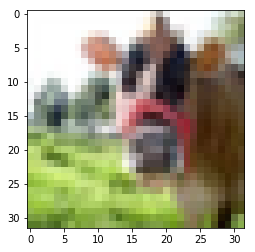

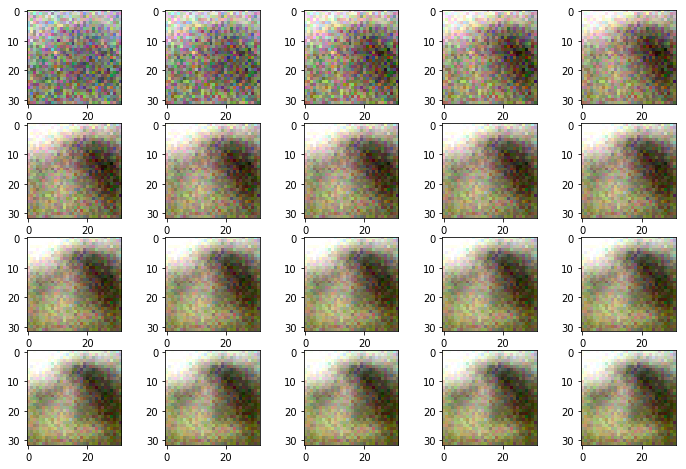

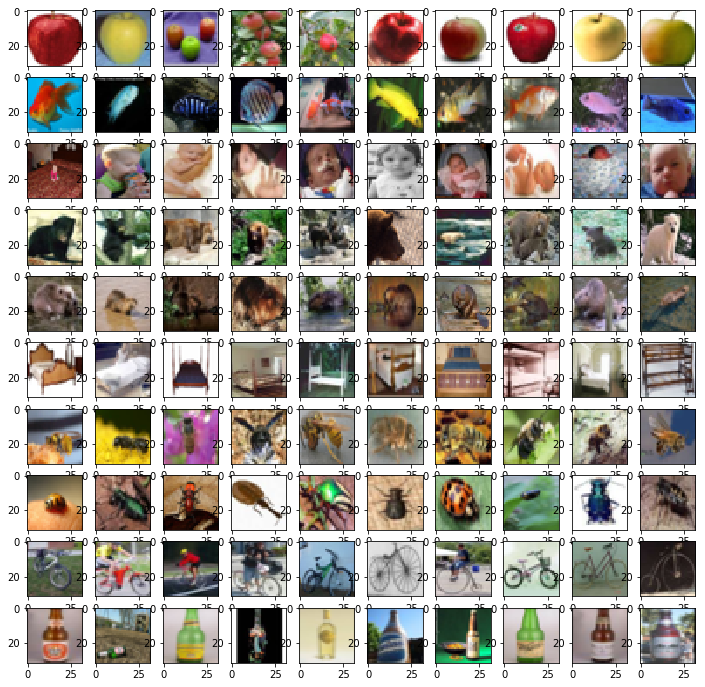

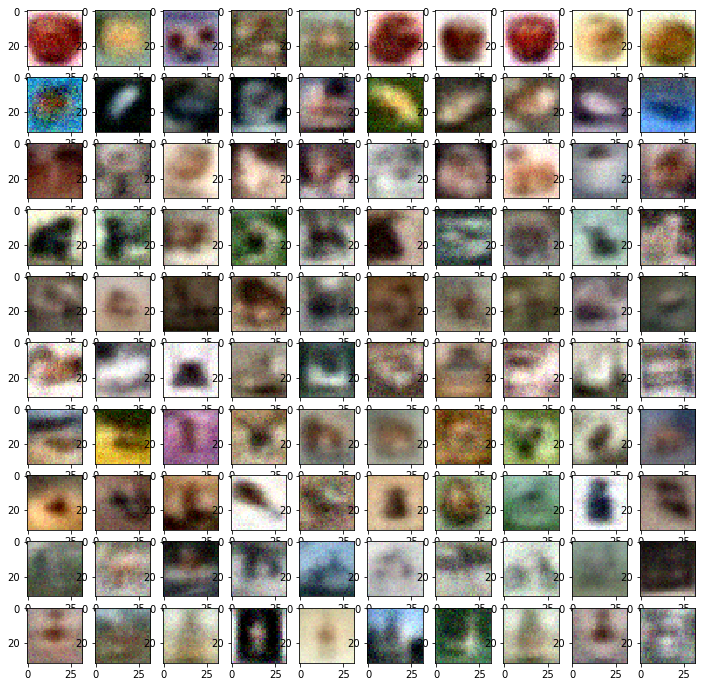

In [3]:
# draw.py
import matplotlib.pyplot as plt
import math
import numpy as np
import chainer
from chainer import Function, FunctionNode, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
import AE
from chainer.training import extensions

gpu_id = 0
def forward(model, datum):
    if gpu_id >= 0:
        dat = chainer.cuda.to_gpu(datum[np.newaxis, :])
        img = model.forward(dat)
        img = chainer.cuda.to_cpu(img.data[0])
    else:
        img = model.forward(datum[np.newaxis, :].data)

    return img


def draw_gray(model_dir, max_epoch):
    train, test = chainer.datasets.get_mnist(ndim=2)
    ae_train, ae_test, model = AE.prepare(train, test)

    fig1, ax1 = plt.subplots()
    ax1.imshow(train[0][0], cmap="gray")

    fig2 = plt.figure(figsize=(12, 8))

    for i in range(20):
        serializers.load_npz(
            '{}/model-{}'.format(model_dir, (i + 1) * (max_epoch // 20)),
            model)

        img = forward(model, ae_train[0][0])
        ax = fig2.add_subplot(4, 5, i + 1)
        ax.imshow(img.reshape(28, 28), cmap="gray")

    idxs = dict()
    for i, d in enumerate(test):
        if not d[1] in idxs:
            idxs[d[1]] = list()
        idxs[d[1]].append(i)

    serializers.load_npz('{}/model-{}'.format(model_dir, max_epoch), model)

    fig3 = plt.figure(figsize=(12, 12))
    fig4 = plt.figure(figsize=(12, 12))
    for i in range(10):
        np.random.shuffle(idxs[i])
        for j, idx in enumerate(idxs[i][:10]):
            ax = fig3.add_subplot(10, 10, i * 10 + j + 1)
            ax.imshow(test[idx][0], cmap="gray")

            img = forward(model, ae_test[idx][0])
            ax = fig4.add_subplot(10, 10, i * 10 + j + 1)
            ax.imshow(img.reshape(28, 28), cmap="gray")

    for i, f in enumerate(plt.get_fignums()):
        plt.figure(f)
        plt.savefig('fig{}.png'.format(i))


def draw_color(model_dir, max_epoch):
    train, test = chainer.datasets.get_cifar100(ndim=3)
    ae_train, ae_test, model = AE.prepare(train, test)

    fig1, ax1 = plt.subplots()
    ax1.imshow(train[0][0].transpose(1, 2, 0))

    fig2 = plt.figure(figsize=(12, 8))

    for i in range(20):
        serializers.load_npz(
            '{}/model-{}'.format(model_dir, (i + 1) * (max_epoch // 20)),
            model)

        img = forward(model, ae_train[0][0])
        ax = fig2.add_subplot(4, 5, i + 1)
        ax.imshow(img.reshape(3, 32, 32).transpose(1, 2, 0))

    idxs = dict()
    for i, d in enumerate(test):
        if not d[1] in idxs:
            idxs[d[1]] = list()
        idxs[d[1]].append(i)

    serializers.load_npz('{}/model-{}'.format(model_dir, max_epoch), model)

    fig3 = plt.figure(figsize=(12, 12))
    fig4 = plt.figure(figsize=(12, 12))
    for i in range(10):
        np.random.shuffle(idxs[i])
        for j, idx in enumerate(idxs[i][:10]):
            ax = fig3.add_subplot(10, 10, i * 10 + j + 1)
            ax.imshow(test[idx][0].transpose(1, 2, 0))

            img = forward(model, ae_test[idx][0])
            ax = fig4.add_subplot(10, 10, i * 10 + j + 1)
            ax.imshow(img.reshape(3, 32, 32).transpose(1, 2, 0))

    for i, f in enumerate(plt.get_fignums()):
        plt.figure(f)
        plt.savefig('fig{}.png'.format(i))

if __name__ == '__main__':
    #draw_gray('reconstruct_mnist', 500)
    draw_color('reconstruct_cifar10', 500)
    #draw_color('reconstruct_cifar100', 500)
